# CNN to Detect Presence of a Fracture in X-ray Images
### Diya Vinod

In [70]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [71]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = "Bone_Fracture_Binary_Classification/train"
val_dir = "Bone_Fracture_Binary_Classification/val"
test_dir = "Bone_Fracture_Binary_Classification/test"

## Data preprocessing
- Normalize pixels
- Data augmentation to prevent overfitting and improve generalization

In [40]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [52]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    'Bone_Fracture_Binary_Classification/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    'Bone_Fracture_Binary_Classification/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    'Bone_Fracture_Binary_Classification/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = False
)
print("Train:", train_data.class_indices)
print("Val:", val_data.class_indices)
print("Test:", test_data.class_indices)

Found 9247 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 507 images belonging to 2 classes.
Train: {'fractured': 0, 'not fractured': 1}
Val: {'fractured': 0, 'not fractured': 1}
Test: {'fractured': 0, 'not fractured': 1}


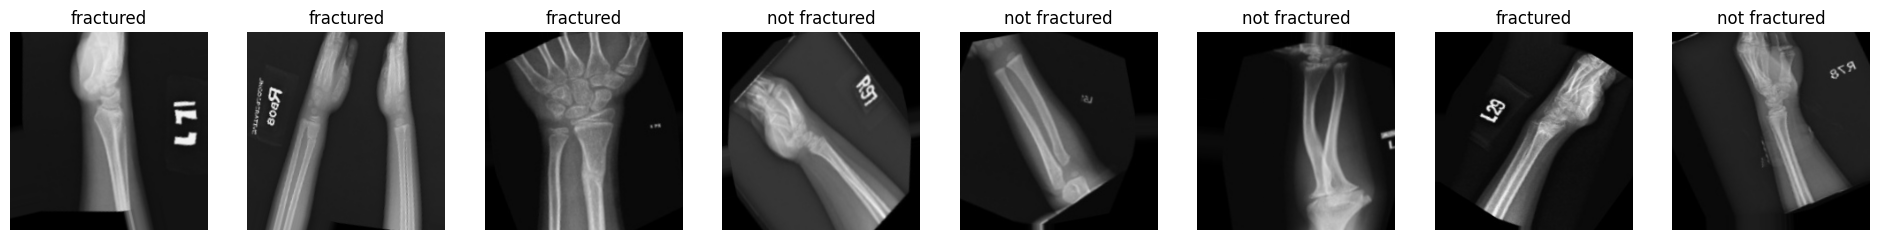

In [42]:
images, labels = next(train_data)  
num_images = 8

plt.figure(figsize=(24,24))

for i in range(num_images):
    ax = plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    label = int(labels[i])
    class_name = list(train_data.class_indices.keys())[label]
    plt.title(class_name)
    plt.axis('off')

plt.show()

## Building the CNN Base

In [43]:
model = models.Sequential([

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,828,033 (37.49 MB)

 Trainable params: 9,827,073 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Compile and train the model

In [44]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0006),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,                  
    restore_best_weights=True    
)

checkpoint = ModelCheckpoint(
    'my_model.keras',
    monitor='val_loss',
    save_best_only=True
)

### Run on validation data

In [45]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,                    
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.7288 - loss: 0.8955 - val_accuracy: 0.7153 - val_loss: 0.9751
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 832s 3s/step - accuracy: 0.8101 - loss: 0.4580 - val_accuracy: 0.7455 - val_loss: 0.6603
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 840s 3s/step - accuracy: 0.8477 - loss: 0.3775 - val_accuracy: 0.5633 - val_loss: 2.5731
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 902s 3s/step - accuracy: 0.8631 - loss: 0.3318 - val_accuracy: 0.8854 - val_loss: 0.3349
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 944s 3s/step - accuracy: 0.8872 - loss: 0.2963 - val_accuracy: 0.9144 - val_loss: 0.2866
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 837s 3s/step - accuracy: 0.9034 - loss: 0.2518 - val_accuracy: 0.9168 - val_loss: 0.3051
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 830s 3s/step - accuracy: 0.9229 - loss: 0.2020 - val_accuracy: 0.8697 - val_loss: 0.3062
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - accuracy: 0.9272 - loss: 0.1934 - val_accu

## Plotting Accuracy over Epochs

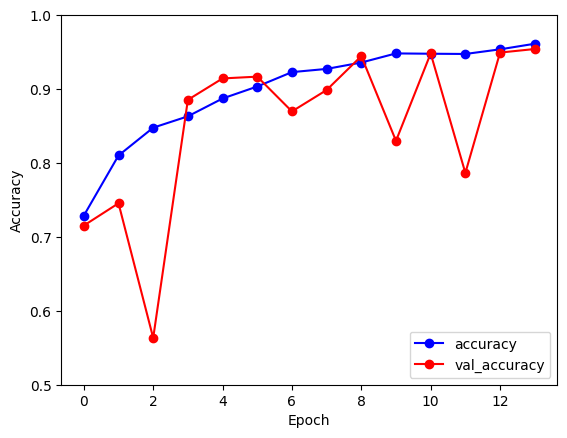

In [47]:
plt.plot(history.history['accuracy'], 'b-o', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Evaluate the CNN Model on the Test Set

In [53]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step - accuracy: 0.9408 - loss: 0.1298
Test Loss: 0.12984296679496765
Test Accuracy: 0.9408283829689026


### Run the model on the test set

In [55]:
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 654ms/step


In [57]:
y_true = test_data.classes

### Confusion Matrix

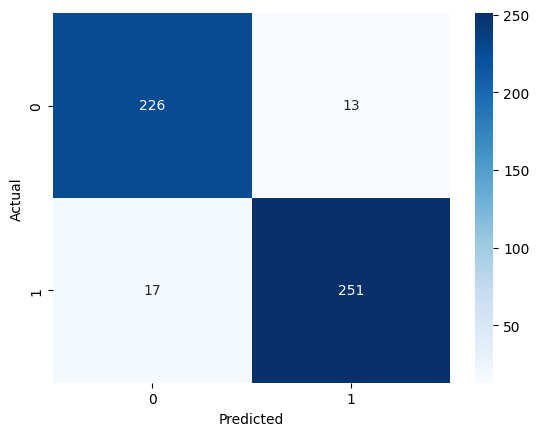

In [64]:
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [63]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       239
           1       0.95      0.94      0.94       268

    accuracy                           0.94       507
   macro avg       0.94      0.94      0.94       507
weighted avg       0.94      0.94      0.94       507

